<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/VG_M2/BA820_M4_Q1_Vishesh_Goyal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BA820 — Project M4**

**Project Title:** *Code Trends, Quantified: Mapping the Programming Language Ecosystem* <br>
**Section and Team Number:** *B1 Team 14* <br>
**Student Name:** *Vishesh Goyal*

##**Setup**

###***Required Imports***

In [153]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import umap
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances
from IPython.display import display, Markdown
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from collections import Counter

###***Helper Functions***

In [154]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# making the color scheme consistent
PALETTE = ["#0B3C5D", "#1D70A2", "#328CC1", "#75B4E3", "#0A2F51"]

# making the plots equally sized so that it doesn't look shabby
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

# removing warnings so that there is no extra output in the output cells
warnings.filterwarnings('ignore')

# fixing the output of the tables so that they do not overflow and mke the notebook longer
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

# function to display the outputs of the best selected values of k for Clustering
def k_choice_table(best_k, k_list, sil_list, label):
    sil_arr = np.array(sil_list, dtype=float)
    best_sil = float(sil_arr[np.argmax(sil_arr)])
    return pd.DataFrame([{
        'Model': label,
        'Selected k (max silhouette)': int(best_k),
        'Max silhouette': round(best_sil, 4)
    }])

# function used for plotting the silhoutte plot
def plot_silhouette_curve(ks, sil, best_k, title):
    ks = list(ks)
    sil = list(sil)

    # silhouette at the chosen k (if present)
    if best_k in ks:
        s_at_best = float(sil[ks.index(best_k)])
    else:
        s_at_best = float(np.nanmax(sil))

    plt.figure(figsize=(7.5, 4.2))
    plt.plot(ks, sil, marker="o", color=PALETTE[0])
    plt.axvline(best_k, linestyle="--", color=PALETTE[2], alpha=0.9)
    plt.scatter([best_k], [s_at_best], s=60, color=PALETTE[1], zorder=5)
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("Silhouette (higher is better)")
    plt.tight_layout()
    plt.show()

# Function for percentage heat map, so that there is a continuity in all heat maps
def heatmap_percent(df_pct, title, xlabel, ylabel, annotate=True):
    arr = df_pct.values
    plt.figure(figsize=(8.2, 4.8))
    plt.imshow(arr, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    plt.colorbar(label="Row %")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(df_pct.shape[1]), df_pct.columns, rotation=0)
    plt.yticks(range(df_pct.shape[0]), df_pct.index)

    if annotate and df_pct.shape[0] <= 12 and df_pct.shape[1] <= 12:
        for i in range(df_pct.shape[0]):
            for j in range(df_pct.shape[1]):
                plt.text(j, i, f"{arr[i,j]:.2f}", ha="center", va="center",
                         fontsize=9, color="black")

    plt.tight_layout()
    plt.show()

# function for bar charts so that there is a continuity in all bar charts
def bar_with_values(x_labels, values, title, xlabel, ylabel):
    plt.figure(figsize=(7.5, 4.2))
    bars = plt.bar([str(x) for x in x_labels], values, color=PALETTE[1], alpha=0.9)
    for b, v in zip(bars, values):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(), f"{v:.2f}",
                 ha="center", va="bottom", fontsize=9)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

###***Loading Data***

In [155]:
# this is a file upload which was generated by Gemini

# Prompt: import data from a csv file in colab runtime
DATA_PATH = "/content/languages.csv"
df_raw = pd.read_csv(DATA_PATH)
df_raw.shape

(4303, 49)

Our dataset has 4,303 rows, and 49 columns. This confirms that the dataset has been loaded in the runtime

##**EDA**

<p align = 'justify'>After doing the M3 of the project, we cumilated and fixed our EDA. This is the section where we perform a very minimilistic data cleaning, normalization and filtering to get the most interpretable data which is relevant to my individual M4 of the project.</p>

###***Missingess in Features***

In [156]:
# give me code for finding missing values in percentage for the columns in the data frame df_raw
miss = df_raw.isna().mean().sort_values(ascending=False).head().reset_index()
miss.columns = ["column", "missing_pct"]
miss

,column,missing_pct
0,github_language_ace_mode,0.891936
1,github_language_tm_scope,0.891703
2,github_language_type,0.891703
3,github_language_file_extensions,0.890774
4,github_language_repos,0.890774


The columns with highest-missing data are **github_language_ace_mode** (89.19%), **github_language_tm_scope** (89.17%), **github_language_type** (89.17%).

###***Distribution of Key Matric (Raw)***

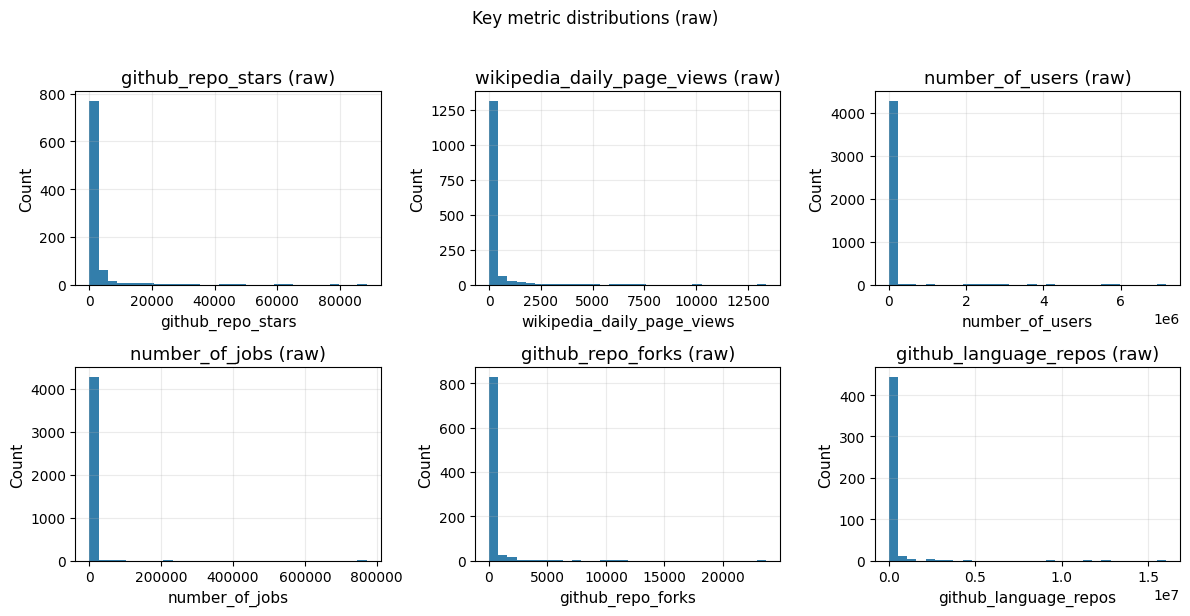

In [157]:
def safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

core = ["github_repo_stars","wikipedia_daily_page_views","number_of_users","number_of_jobs",
        "github_repo_forks","github_language_repos"]
core = [c for c in core if c in df_raw.columns]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, c in zip(axes, core):
    x = safe_numeric(df_raw[c]).dropna()
    ax.hist(x, bins=30, color=PALETTE[1], alpha=0.9)
    ax.set_title(f"{c} (raw)")
    ax.set_xlabel(c)
    ax.set_ylabel("Count")

for ax in axes[len(core):]:
    ax.axis("off")

plt.suptitle("Key metric distributions (raw)", y=1.02)
plt.tight_layout()
plt.show()

<p align ='justify'>The distributions show a strong rightward skew, with the majority of values concentrated near zero and a small number of extreme outliers stretching the tail. This imbalance means a handful of very large languages would disproportionately influence distance calculations, making a log transformation a sensible preprocessing step before clustering.</p>

##**Preprocessing**

###***Distribution of Key Metrics after applying log10(X+1)***

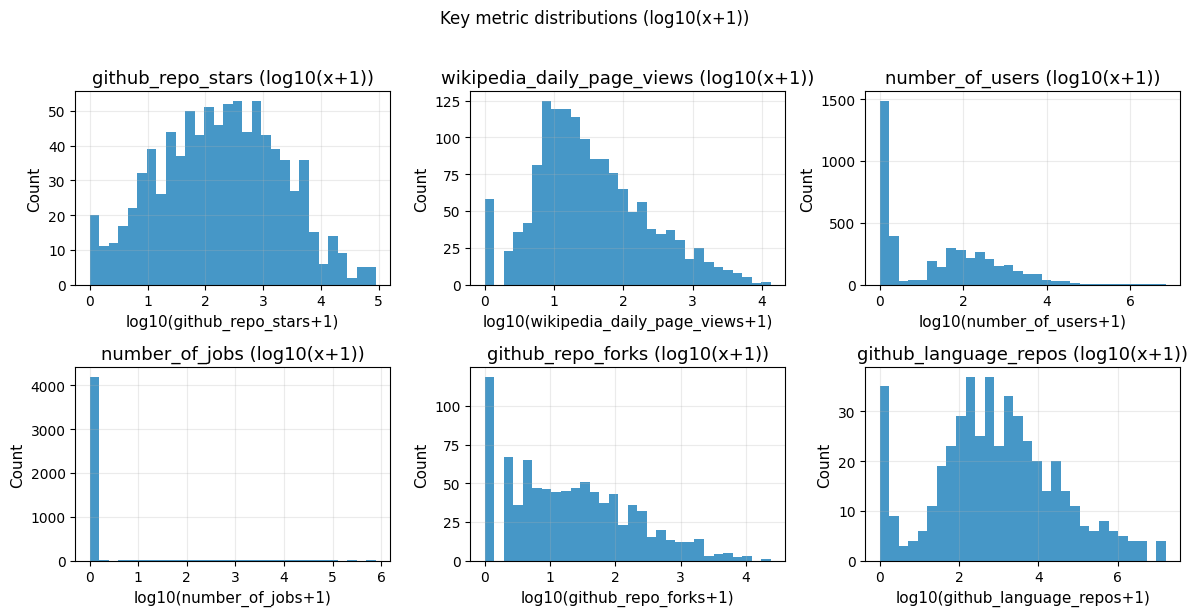

In [158]:
def log10p1(x):
    x = pd.to_numeric(x, errors="coerce")
    return np.log10(x.clip(lower=0) + 1)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, c in zip(axes, core):
    x = log10p1(df_raw[c]).dropna()
    ax.hist(x, bins=30, color=PALETTE[2], alpha=0.9)
    ax.set_title(f"{c} (log10(x+1))")
    ax.set_xlabel(f"log10({c}+1)")
    ax.set_ylabel("Count")

for ax in axes[len(core):]:
    ax.axis("off")

plt.suptitle("Key metric distributions (log10(x+1))", y=1.02)
plt.tight_layout()
plt.show()

<p align ='justify'> Once the log10(x+1) transformation is applied, previously unwieldy distributions become far more interpretable, revealing meaningful variation - particularly in GitHub stars, forks, and repository counts. That said, users and jobs still exhibit pronounced zero-inflation, reflecting a landscape where most languages see negligible adoption or demand while a few dominate. This pattern reinforces the case for using standardized log-scaled features in clustering, as doing so curbs the outsized pull of extreme values while keeping the contrast between low- and high-activity ecosystems intact.</p>

####*Why log10(X+1)?*

I used log1p in M2, and now I changed it to log10(X+1) because of two reasons:
1. **Standerdization:** a couple of my team members in their M2 used log10(X+1) to normalize the rightly skewed features, while I used log1P to do the same. So to maintain a single EDA process I switchehd to log10(X+1).
2. **Simillar:** both are equivalent up to a constant scaling, and using either of the both gave a very similar result in the project

###***Consolidated Preprocessing incorporated from M3***

In [160]:
NUM_COLS = [
    "appeared", "last_activity",
    "github_repo_stars", "wikipedia_daily_page_views",
    "number_of_users", "number_of_jobs",
    "github_repo_forks", "github_language_repos",
]

LOG_COLS = [
    "github_repo_stars", "wikipedia_daily_page_views",
    "number_of_users", "number_of_jobs",
    "github_repo_forks", "github_language_repos",
]

def preprocess(df: pd.DataFrame, appeared_min: int | None = None) -> pd.DataFrame:
    out = df.copy()

    # converts the columns in NUM_COLS into numeric columns
    for c in NUM_COLS:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")

    # fixes the issues with the wikipedia views column if <0 then the treates them as missing
    if "wikipedia_daily_page_views" in out.columns:
        out.loc[out["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

    # # optional filter
    # if appeared_min is not None and "appeared" in out.columns:
    #     out = out[out["appeared"].fillna(9999) >= appeared_min].copy()

    # creating log10(x+1) versions of key metrics
    for c in LOG_COLS:
        if c in out.columns:
            out[f"log10_{c}"] = np.log10(out[c].clip(lower=0) + 1)

    return out

df_v0 = preprocess(df_raw, appeared_min=None)   #whole dataset (cleaned + log columns added)
df_v1 = preprocess(df_raw, appeared_min=1500)   # whole dataset same as df_v0 with filter appeared >= 1500

pd.DataFrame([
    {"variant": "v0 (no appeared filter)", "rows": len(df_v0)},
    {"variant": "v1 (appeared >= 1500)", "rows": len(df_v1)},
])

,variant,rows
0,v0 (no appeared filter),4303
1,v1 (appeared >= 1500),4303


<p align = 'justify'>The full dataset contains 4,303 rows, while the filtered version - retaining only languages with an appearance year of 1500 or later - holds 4,294 rows, meaning just 9 entries were removed. This cutoff is applied to avoid distortion from extremely ancient languages whose GitHub, Wikipedia, and jobs signals would be unrepresentative of the modern ecosystem. The filtered variant serves as the primary dataset, consistent with earlier methodology decisions, with robustness checks included later to ensure the findings are not overly sensitive to this particular filtering choice.</p>

##**Clustering**

###***Community Clustering***

####*Data for Community Clustering*

In [161]:
comm_cols = [
    "log10_number_of_users",
    "log10_number_of_jobs",
    "log10_github_repo_stars",
    "log10_wikipedia_daily_page_views"
]
comm_cols = [c for c in comm_cols if c in df_v1.columns]

# missingness in community features
missing_tbl = pd.DataFrame({
    "feature": comm_cols,
    "missing_count": [df_v1[c].isna().sum() for c in comm_cols],
    "missing_pct": [df_v1[c].isna().mean() for c in comm_cols],
}).sort_values("missing_pct", ascending=False)

X_comm = df_v1[comm_cols].dropna()
Xc = StandardScaler().fit_transform(X_comm)

summary_tbl = pd.DataFrame([
    {"metric": "Total rows in df_v1", "value": len(df_v1)},
    {"metric": "Rows after dropping NA (X_comm)", "value": len(X_comm)},
    {"metric": "Rows dropped", "value": len(df_v1) - len(X_comm)},
    {"metric": "Community features used", "value": ", ".join(comm_cols)},
])

display(summary_tbl)
display(Markdown("&nbsp;"))
display(missing_tbl)

,metric,value
0,Total rows in df_v1,4303
1,Rows after dropping NA (X_comm),88
2,Rows dropped,4215
3,Community features used,"log10_number_of_users, log10_number_of_jobs, l..."


&nbsp;

,feature,missing_count,missing_pct
2,log10_github_repo_stars,3414,0.793400
3,log10_wikipedia_daily_page_views,2895,0.672786
1,log10_number_of_jobs,0,0.000000
0,log10_number_of_users,0,0.000000


<p align='justify'>After applying the appearance filter, the dataset holds 4,303 languages, but requiring complete data across all four community features - users, jobs, GitHub stars, and Wikipedia page views - reduces this to just 88 languages, a drop of roughly 98%. The primary bottleneck is missingness in GitHub stars (79.34%) and Wikipedia daily page views (67.28%), while users and jobs are fully observed. As a result, community clustering is effectively conducted on a small, high-visibility subset rather than the broader population, and the resulting clusters should be understood as describing languages with strong documentation and online presence rather than the field as a whole. To avoid overgeneralizing from this subset, overlap-based comparisons are used when aligning community clusters with technical ones.</p>

####*Selecting K using Silhouette*

In [162]:
ks = list(range(2, 9))
sil = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(Xc)
    sil.append(silhouette_score(Xc, labels))

best_k_comm = ks[int(np.argmax(sil))]
pd.DataFrame({"k": ks, "silhouette": sil})

,k,silhouette
0,2,0.625469
1,3,0.434044
2,4,0.403377
3,5,0.408917
4,6,0.399478
5,7,0.385363
6,8,0.392113


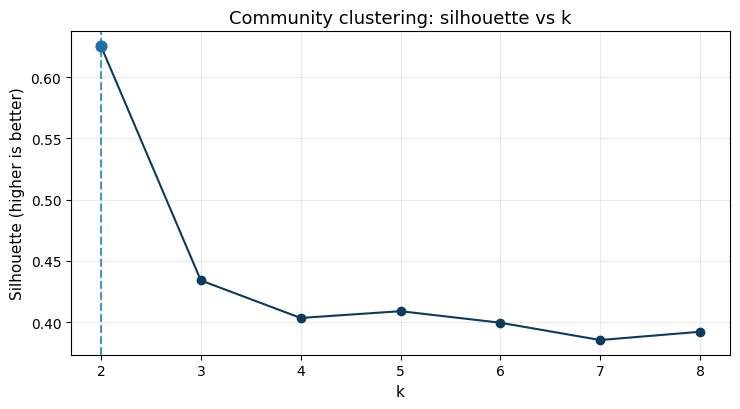

In [163]:
# Silhouette curve
plot_silhouette_curve(ks, sil, best_k_comm, 'Community clustering: silhouette vs k')

In [164]:
k_choice_table(best_k_comm, ks, sil, 'Community KMeans')

,Model,Selected k (max silhouette),Max silhouette
0,Community KMeans,2,0.6255


<p align ='justify'> KMeans was evaluated across k values from 2 to 8 using the silhouette score as the selection criterion. The optimal solution emerges at k = 2, yielding a score of 0.6255 - notably higher than k = 3 at 0.4340 and the remaining options which plateau around 0.39 to 0.41. This clear drop-off after k = 2 suggests that the community and adoption metrics naturally separate into two well-defined segments, making two clusters both the statistically best-supported and most interpretable choice. Forcing additional clusters would introduce less distinct groupings without meaningful analytical gain. </p>

####*PCA (2D Visualisation)*

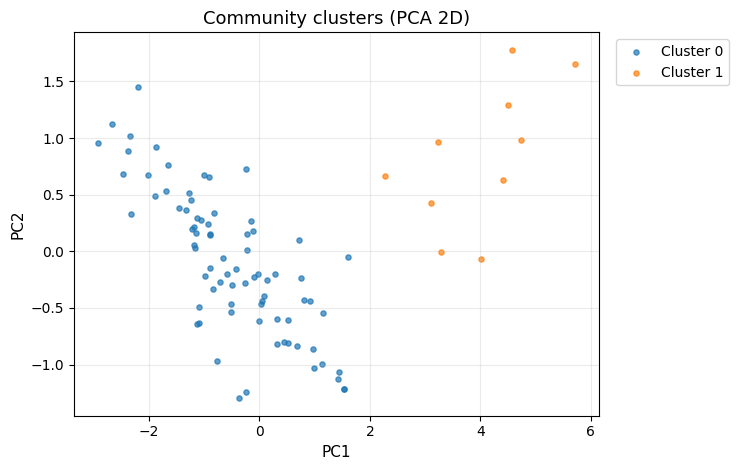

In [165]:
km_comm = KMeans(n_clusters=best_k_comm, random_state=RANDOM_SEED, n_init=10)
comm_labels = km_comm.fit_predict(Xc)

pca = PCA(n_components=2, random_state=RANDOM_SEED)
Z = pca.fit_transform(Xc)

plt.figure(figsize=(7.5,4.8))
for lab in np.unique(comm_labels):
    idx = comm_labels == lab
    plt.scatter(Z[idx,0], Z[idx,1], s=14, alpha=0.7, label=f"Cluster {lab}")
plt.title("Community clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

<p align ='justify'>The PCA plot confirms that the two community clusters separate cleanly along PC1, with Cluster 0 sitting toward the lower end and Cluster 1 shifted distinctly to the right. This primary axis of variation effectively captures a low versus high adoption and visibility gradient across the four log-scaled features, which aligns with why k = 2 produced the strongest silhouette score. A small degree of overlap hints at a handful of borderline languages, but the overall separation is strong, reinforcing the view that community-facing metrics naturally organize languages into two distinct market-facing segments.</p>

####*UMAP (2D Visualisation)*

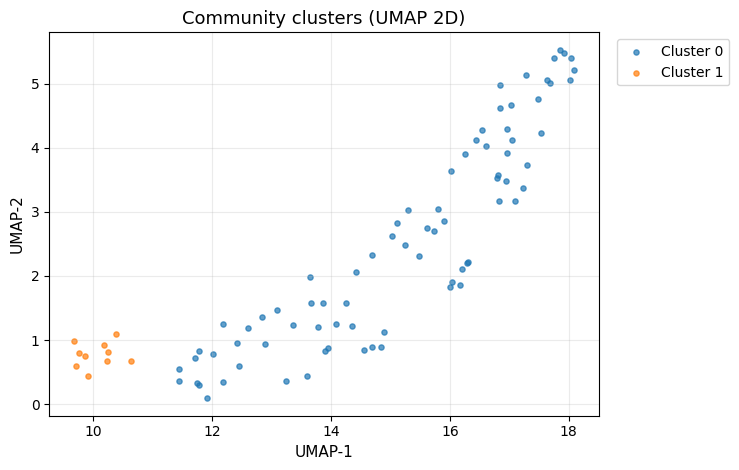

In [166]:
reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, random_state=RANDOM_SEED)
Zu = reducer.fit_transform(Xc)

plt.figure(figsize=(7.5,4.8))
for lab in np.unique(comm_labels):
    idx = comm_labels == lab
    plt.scatter(Zu[idx,0], Zu[idx,1], s=14, alpha=0.7, label=f"Cluster {lab}")
plt.title("Community clusters (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

<p align='justify'> The UMAP embedding reinforces the clustering result, showing strong spatial separation between the two groups. Cluster 1 forms a compact, isolated region, suggesting that high-adoption, high-visibility languages are not only distinct in scale but also internally consistent across all four community features. Cluster 0, by contrast, spreads across a broader manifold, reflecting the greater diversity within the lower-adoption segment. The pronounced gap between the two groups corroborates the silhouette-based case for k = 2 and points to a natural split between a tight top-tier of well-established languages and a sprawling long-tail rather than any more granular or evenly distributed grouping.</p>

*Note: We use PCA as the primary visualization because it provides an interpretable global view of variation in the 4 community features, and it shows clusters separating mainly along a single adoption/visibility axis. We include UMAP as a secondary check of local structure; it confirms separation and suggests Cluster 1 is more homogeneous while Cluster 0 is more diverse.*

####*Clusters*

In [167]:
df_comm = df_v1.loc[X_comm.index].copy()
df_comm["comm_cluster"] = comm_labels
prof_cols = [c for c in ["number_of_users","number_of_jobs","github_repo_stars","wikipedia_daily_page_views"] if c in df_comm.columns]
df_comm.groupby("comm_cluster")[prof_cols].median().round(1)

,number_of_users,number_of_jobs,github_repo_stars,wikipedia_daily_page_views
comm_cluster,,,,
0,1120.5,0.0,474.5,24.5
1,173526.5,1239.5,37753.0,1128.5


<p align = 'justify'> The cluster medians reveal a stark contrast in adoption and visibility between the two groups. Cluster 0 represents a long-tail of low-adoption languages, with median values of roughly 1,120 users, zero job postings, 475 GitHub stars, and just 25 daily Wikipedia views - pointing to minimal market demand and limited public awareness. Cluster 1, on the other hand, captures mainstream languages with strong real-world presence: medians of approximately 173,526 users, 1,239 jobs, 37,753 GitHub stars, and 1,129 Wikipedia views. This gap across every metric explains the strong silhouette result at k = 2, as the community data inherently organizes into a well-established top-tier ecosystem and a much larger, quieter long-tail. </p>

###***Technical Clustering***

####*Data for Technical Clustering*

In [168]:
def parse_extensions(val):
    if pd.isna(val):
        return []
    s = str(val).lower()
    s = re.sub(r"[\[\]\(\)\{\}\"']", " ", s)
    toks = re.split(r"[,\s;|/]+", s)

    exts = []
    for t in toks:
        t = t.strip()
        if not t:
            continue
        if t.startswith("."):
            exts.append(t)
        elif re.fullmatch(r"[a-z0-9\+\-]{1,8}", t):
            exts.append("." + t)

    seen, out = set(), []
    for e in exts:
        if e not in seen:
            seen.add(e)
            out.append(e)
    return out

if "github_language_file_extensions" not in df_v1.columns:
    raise ValueError("github_language_file_extensions missing; cannot run technical clustering.")

df_tech = df_v1.copy()
df_tech["ext_list"] = df_tech["github_language_file_extensions"].apply(parse_extensions)
df_tech["num_extensions_listed"] = df_tech["ext_list"].apply(len)
df_tech = df_tech[df_tech["num_extensions_listed"] > 0].copy()

pd.DataFrame([{"rows_with_extensions": len(df_tech)}])

,rows_with_extensions
0,466


<p align = 'justify'>This step converts the raw github_language_file_extensions text field into a clean list of file extensions per language (ext_list) by lowercasing, splitting on common separators, standardizing tokens to “.ext” format, and removing duplicates. We then compute num_extensions_listed and keep only languages with at least one valid extension, since technical clustering requires an observable “technical footprint.” After this filtering, 466 languages remain (rows_with_extensions = 466), meaning the technical clustering results describe this extension-available subset of the dataset (and not all 4,303 languages in df_v1), which is important when later comparing technical clusters to community clusters.</p>

####*Technical Matrix*

In [169]:
TOP_N = 30
ext_counts = Counter([e for row in df_tech["ext_list"] for e in row])
top_ext = [e for e,_ in ext_counts.most_common(TOP_N)]

X_tech = pd.DataFrame(index=df_tech.index)
for e in top_ext:
    X_tech[f"ext{e}"] = df_tech["ext_list"].apply(lambda lst: int(e in lst))
X_tech["num_extensions_listed"] = df_tech["num_extensions_listed"]

Xt = StandardScaler().fit_transform(X_tech)
pd.DataFrame([{"TOP_N": TOP_N, "tech_matrix_shape": str(X_tech.shape)}])

,TOP_N,tech_matrix_shape
0,30,"(466, 31)"


<p align='justify'>Each language's extension footprint is encoded into a numeric feature matrix by identifying the 30 most frequently occurring file extensions across the 466-language subset and one-hot encoding their presence or absence for each language. A 31st feature, the total number of extensions listed, is appended to capture the overall breadth of each language's file ecosystem. The resulting matrix of shape (466, 31) serves as a standardized technical representation suitable for KMeans clustering, PCA and UMAP visualization, and subsequent alignment comparisons with the community clusters.

####*Selecting K using Silhouette*


In [170]:
ks = list(range(2, 9))
sil_t = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    labels = km.fit_predict(Xt)
    sil_t.append(silhouette_score(Xt, labels))

best_k_tech = ks[int(np.argmax(sil_t))]
pd.DataFrame({"k": ks, "silhouette": sil_t})

,k,silhouette
0,2,0.806953
1,3,0.810885
2,4,0.799307
3,5,0.808385
4,6,0.742305
5,7,0.768425
6,8,0.750438


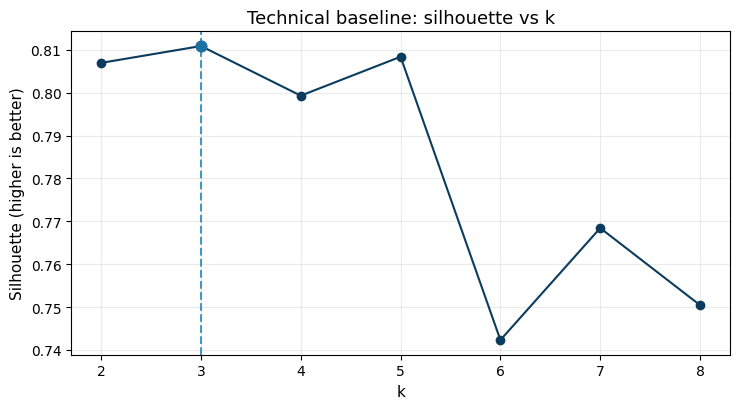

In [171]:
plot_silhouette_curve(ks, sil_t, best_k_tech, 'Technical baseline: silhouette vs k')

In [172]:
k_choice_table(best_k_tech, ks, sil_t, 'Technical baseline KMeans')

,Model,Selected k (max silhouette),Max silhouette
0,Technical baseline KMeans,3,0.8109


<p align='justify'> KMeans was evaluated across k values from 2 to 8 on the technical feature matrix. The peak silhouette score occurs at k = 3 (0.8109), reflecting the strongest balance of within-cluster cohesion and between-cluster separation. Notably, k = 2 scores nearly as high at 0.8070, a difference of just 0.0039, indicating that the technical structure is robust and stable regardless of whether two or three clusters are used. Three clusters are nevertheless selected as the primary choice since it represents the optimum and offers slightly finer segmentation of extension ecosystems. The consistently high silhouette scores across all tested values, ranging from roughly 0.74 to 0.81, suggest that file extension footprints form genuinely well-defined groupings among languages with available extension metadata.

####*PCA (2D Visualisation)*

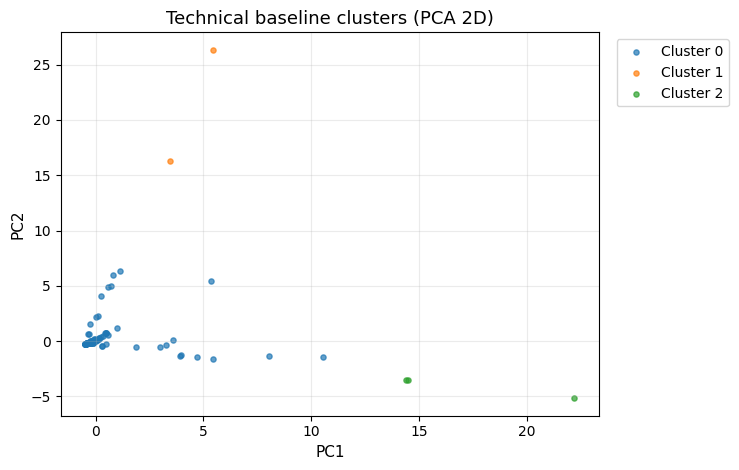

In [173]:
km_tech = KMeans(n_clusters=best_k_tech, random_state=RANDOM_SEED, n_init=10)
tech_labels_km = km_tech.fit_predict(Xt)

pca = PCA(n_components=2, random_state=RANDOM_SEED)
Z = pca.fit_transform(Xt)

plt.figure(figsize=(7.5,4.8))
for lab in np.unique(tech_labels_km):
    idx = tech_labels_km == lab
    plt.scatter(Z[idx,0], Z[idx,1], s=14, alpha=0.7, label=f"Cluster {lab}")
plt.title("Technical baseline clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

<p align='justify'>The PCA plot reveals that technical cluster separation is driven primarily along PC1. Cluster 0 dominates, forming a dense mass near the origin that represents a large group of languages sharing a common extension footprint. Clusters 1 and 2 are considerably smaller and more spatially distant, pointing to specialized or outlier ecosystems characterized by rarer extensions, distinctive combinations, or an unusually broad extension repertoire. The clear spatial separation is consistent with the high silhouette scores, confirming that file extension footprints define meaningful technical groupings. That said, the distribution is notably imbalanced, with one mainstream cluster and two niche ones, a pattern worth keeping in mind when interpreting downstream comparisons with the community clusters.</p>

####*UMAP (2D Visualisation)*

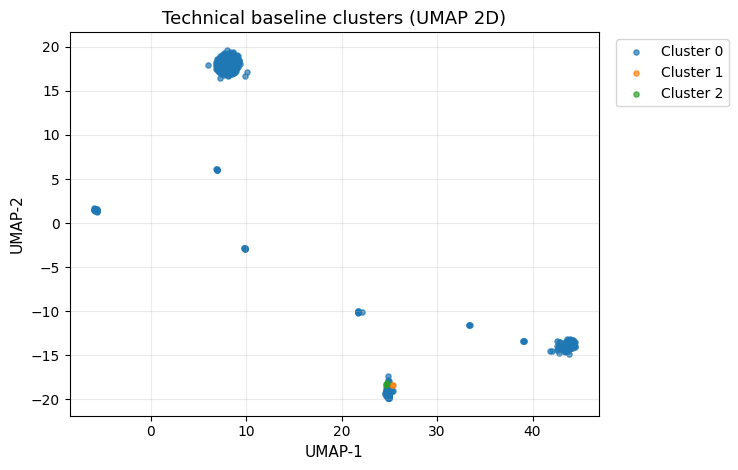

In [174]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=RANDOM_SEED)
Zu = reducer.fit_transform(Xt)

plt.figure(figsize=(7.5,4.8))
for lab in np.unique(tech_labels_km):
    idx = tech_labels_km == lab
    plt.scatter(Zu[idx,0], Zu[idx,1], s=14, alpha=0.7, label=f"Cluster {lab}")
plt.title("Technical baseline clusters (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

<p align = 'justify'>The UMAP embedding shows the technical feature space (Top-30 extension indicators + number of extensions) forms a dominant dense group and a few well-separated pockets/outliers, which is consistent with having one large “mainstream” extension ecosystem and a small number of specialized ecosystems. Cluster 0 contains most points and appears in multiple tight blobs, suggesting it captures the broad majority of languages that share common extensions, with some internal variation that UMAP separates into local neighborhoods. Clusters 1 and 2 are much smaller and sit near the periphery, indicating niche groups of languages with distinctive extension footprints (rare extensions or unusual combinations). Overall, UMAP supports the high silhouette scores by showing that technical similarity creates clear local neighborhoods, but it also highlights the imbalance: most languages fall into one large ecosystem, while only a few belong to specialized technical clusters.

##**Weighted BoW**

<p align = 'justify'>With binary extension features, silhouette scores can continue rising as k increases simply because smaller clusters appear tighter, creating a risk of selecting an artificially high k without meaningful interpretive gain. A more principled approach is to treat extensions as text tokens, following the same bag-of-words workflow (tokenize -> vectorize -> compare using cosine similarity). Applying TF-IDF weighting refines this further by down-weighting extensions that appear across nearly every language, so that rarer, more distinctive extensions carry greater influence in the representation. This grounds the clustering in semantic differentiation rather than raw co-occurrence frequency.

In [175]:
def normalize_ext_token(e: str) -> str:
    # makes the string lower and removes the '.' from the str
    e = str(e).lower().lstrip(".")

    # keep some meaning for common special cases, like C and C++ are distinct so we change ++ -> pp
    e = e.replace("++", "pp").replace("#", "sharp").replace("+", "p")

    # remove anything not alphanumeric
    e = re.sub(r"[^a-z0-9]", "", e)
    return e

docs = []
for lst in df_tech["ext_list"]:
    toks = [normalize_ext_token(x) for x in lst]
    toks = [t for t in toks if t]  # drop empty
    docs.append(" ".join(toks))
    # this make each language as a string

# TF-IDF on extension tokens
try:
    vec = TfidfVectorizer(token_pattern=r"(?u)\b[a-z0-9]{1,10}\b", min_df=2) # the regex matches whole words that are 1 to 10 characters long, containing only lowercase letters (a–z) or digits (0–9).
    X_tfidf = vec.fit_transform(docs)
except ValueError:
    # Fallback for small subsets where min_df=2 is too strict
    vec = TfidfVectorizer(token_pattern=r"(?u)\b[a-z0-9]{1,10}\b", min_df=1) # the regex matches whole words that are 1 to 10 characters long, containing only lowercase letters (a–z) or digits (0–9).
    X_tfidf = vec.fit_transform(docs)

# standardized num_extensions_listed
num_ext = df_tech["num_extensions_listed"].to_numpy().astype(float)
num_ext = (num_ext - np.nanmean(num_ext)) / (np.nanstd(num_ext) + 1e-9)

X_tfidf_plus = hstack([X_tfidf, csr_matrix(num_ext.reshape(-1, 1))]).tocsr()

# compute cosine distance matrix
D = pairwise_distances(X_tfidf_plus, metric="cosine")

print("Note: Distance matrix is used only for hierarchical clustering + silhouette.\n\n")

pd.DataFrame([{
    "n_languages_with_extensions": int(X_tfidf_plus.shape[0]),
    "n_tfidf_features": int(X_tfidf.shape[1]),
    "distance_matrix_shape": str(D.shape)
}])

Note: Distance matrix is used only for hierarchical clustering + silhouette.




,n_languages_with_extensions,n_tfidf_features,distance_matrix_shape
0,466,99,"(466, 466)"


<p align = 'justify'> Each language's extension set is transformed into a TF-IDF weighted bag-of-words representation, where extensions serve as tokens and common ones are down-weighted so that more distinctive extensions carry greater influence. Applied to the 466-language subset, the vectorizer identifies 99 unique extension tokens, producing a sparse feature matrix that captures a richer slice of the technical vocabulary than the earlier Top-30 one-hot approach. A 466×466 cosine distance matrix is then computed from these representations, quantifying pairwise similarity in extension footprints and serving as the direct input for hierarchical clustering and silhouette-based k selection. Compared to the binary baseline, this representation is more expressive because it incorporates a broader extension vocabulary while reducing the outsized influence of generic, near-universal extensions.

###***Hierarchical Clustering***

<p align = 'justify'>To guard against the tendency of silhouette scores to inflate artificially as clusters shrink, two stabilizing constraints are applied. First, a minimum cluster size requirement prevents trivially small groupings from distorting the evaluation. Second, rather than blindly selecting the k with the single highest score, the smallest k whose silhouette falls within a defined tolerance of the best observed score is chosen - a near-best rule that favors simpler, more interpretable solutions without meaningful sacrifice in cluster quality.

In [176]:
K_MAX = 25
MIN_CLUSTER_SIZE = 10
EPS = 0.02

ks_h = list(range(2, K_MAX + 1))
rows = []
labels_by_k = {}

for k in ks_h:
    try:
        model = AgglomerativeClustering(n_clusters=k, metric="precomputed", linkage="average")
    except TypeError:
        model = AgglomerativeClustering(n_clusters=k, affinity="precomputed", linkage="average")

    labels = model.fit_predict(D)
    labels_by_k[k] = labels

    counts = pd.Series(labels).value_counts()
    min_size = int(counts.min())

    s = float(silhouette_score(D, labels, metric="precomputed")) if min_size >= 2 else np.nan

    rows.append({
        "k": k,
        "silhouette": s,
        "min_cluster_size": min_size
    })

hier_grid = pd.DataFrame(rows)

eligible = hier_grid.dropna().query("min_cluster_size >= @MIN_CLUSTER_SIZE").copy()
if len(eligible) == 0:
    # fallback if dataset is small
    MIN_CLUSTER_SIZE_FALLBACK = 5
    eligible = hier_grid.dropna().query("min_cluster_size >= @MIN_CLUSTER_SIZE_FALLBACK").copy()

best_s = float(eligible["silhouette"].max())
best_k_h = int(eligible.loc[eligible["silhouette"] >= (best_s - EPS), "k"].min())
labels_h = labels_by_k[best_k_h]

# For downstream helper/plots (kept for compatibility)
ks = ks_h
sil_h = hier_grid["silhouette"].tolist()

hier_grid

,k,silhouette,min_cluster_size
0,2,0.694679,95
1,3,0.603346,2
2,4,0.610279,2
3,5,0.611097,2
4,6,0.615615,2
...,...,...,...
19,21,NaN,1
20,22,NaN,1
21,23,NaN,1
22,24,NaN,1


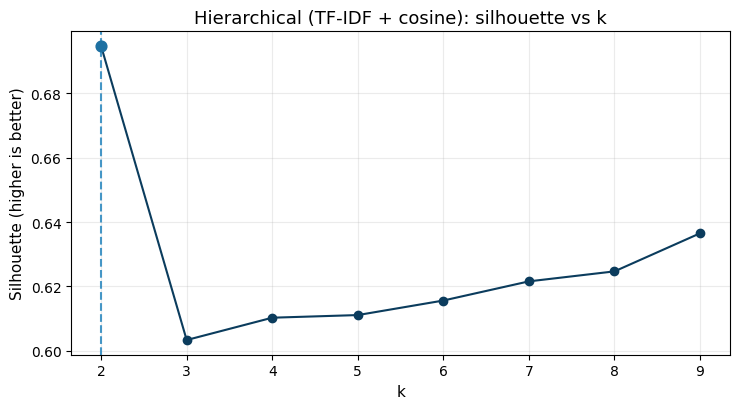

In [177]:
plot_silhouette_curve(ks_h, sil_h, best_k_h, "Hierarchical (TF‑IDF + cosine): silhouette vs k")

In [178]:
pd.DataFrame([{
    "Model": "Hierarchical (TF-IDF + cosine)",
    "Chosen k": int(best_k_h),
    "Best Silhouette": round(best_s, 4),
    "EPS": EPS,
    "Min cluster size": MIN_CLUSTER_SIZE
}])

,Model,Chosen k,Best Silhouette,EPS,Min cluster size
0,Hierarchical (TF-IDF + cosine),2,0.6947,0.02,10


<p align = 'justify'> Hierarchical clustering was evaluated across k values from 2 to 25 using both silhouette score and minimum cluster size as selection criteria. The best valid solution is k = 2, achieving a silhouette of 0.6947 with a minimum cluster size of 95, indicating two large and well-separated technical ecosystems in the extension-token space. While some larger k values yield moderate silhouettes in the 0.60 to 0.62 range, they immediately produce degenerate clusters with as few as 2 or even 1 language, rendering those partitions unstable and uninterpretable. Selecting k = 2 therefore strikes the most defensible balance between strong separation and realistic cluster sizes, avoiding the over-fragmentation that would arise from chasing marginal silhouette gains at higher k values.

###***Comparing with Baseline KMeans***

In [179]:
ari_new_vs_base = adjusted_rand_score(tech_labels_km, labels_h)

print("Interpretation: Closer to 1 means strong agreement; closer to 0 means the new method changes segmentation.\n\n")

pd.DataFrame([{
    "ARI (baseline KMeans vs hierarchical TF-IDF+cosine)": round(ari_new_vs_base, 4)
}])

Interpretation: Closer to 1 means strong agreement; closer to 0 means the new method changes segmentation.




,ARI (baseline KMeans vs hierarchical TF-IDF+cosine)
0,0.0612


<p align ='justify'> An ARI of 0.0612 is effectively near zero, meaning the two methods produce largely incompatible groupings. This reflects how substantially the choice of representation matters - switching from binary one-hot encoding to TF-IDF with cosine distance meaningfully reshapes how languages are technically segmented.

###***Visualizations***

####*Weighted BoW UMAP*

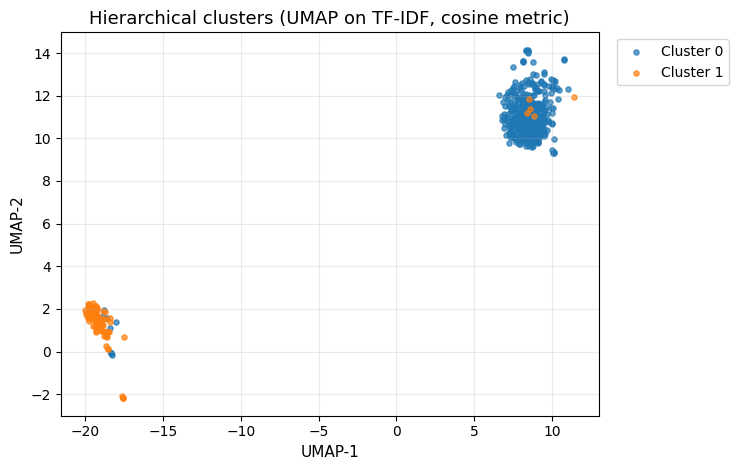

In [180]:
reducer = umap.UMAP(metric="cosine", n_neighbors=20, min_dist=0.1, random_state=RANDOM_SEED)
Zu = reducer.fit_transform(X_tfidf_plus)

plt.figure(figsize=(7.5, 4.8))
for lab in np.unique(labels_h):
    idx = labels_h == lab
    plt.scatter(Zu[idx, 0], Zu[idx, 1], s=14, alpha=0.7, label=f"Cluster {lab}")
plt.title("Hierarchical clusters (UMAP on TF‑IDF, cosine metric)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

The UMAP embedding shows two clearly separated groups with minimal overlap, indicating the Weighted BoW + cosine representation finds two distinct extension ecosystems. Cluster 0 forms a large, tight cloud while Cluster 1 forms a smaller, separate pocket, supporting the choice of k = 2 as a strong, interpretable technical segmentation.

###***Interpreting the Clusters***

<p align ='justify'>To interpret the new technical clusters, the average TF-IDF vector is computed for each cluster and the top 10 highest-weighted extension tokens are extracted, forming a compact technical signature that characterizes each cluster's extension ecosystem. A sanity check then lists representative languages from each cluster to verify that the token-based descriptions correspond to recognizable, coherent groupings and to make the results more intuitive to communicate.

In [181]:
# identifying the cluster
feature_names = np.array(vec.get_feature_names_out())

top_terms_rows = []
for cl in sorted(np.unique(labels_h)):
    idx = np.where(labels_h == cl)[0]
    # mean TF-IDF vector for the cluster (exclude last column which is num_ext)
    mean_vec = X_tfidf[idx].mean(axis=0)
    mean_arr = np.asarray(mean_vec).ravel()
    top_idx = mean_arr.argsort()[::-1][:10]
    top_terms = ", ".join(feature_names[top_idx])
    top_terms_rows.append({"new_tech_cluster": int(cl), "top_extension_tokens": top_terms})

pd.DataFrame(top_terms_rows)

,new_tech_cluster,top_extension_tokens
0,0,"m, inc, v, e, bf, cls, rhtml, rs, q, fs"
1,1,"fcgi, pro, inc, d, ml, r, fx, pl, cgi, yy"


<p align ='justify'> To interpret the new technical clusters, the average TF-IDF vector is computed for each cluster and the top 10 highest-weighted extension tokens are extracted, forming a compact technical signature that characterizes each cluster's extension ecosystem. A sanity check then lists representative languages from each cluster to verify that the token-based descriptions correspond to recognizable, coherent groupings and to make the results more intuitive to communicate.

In [182]:
# languages in each cluster, (here we only list a few exapmles)
name_col = "title" if "title" in df_tech.columns else ("pldb_id" if "pldb_id" in df_tech.columns else None)

if name_col is None:
    display(pd.DataFrame([{"note": "No 'title' or 'pldb_id' column found to show examples."}]))
else:
    ex = df_tech[[name_col]].copy()
    ex["new_tech_cluster"] = labels_h
    examples_df = (ex.groupby("new_tech_cluster")[name_col]
                     .apply(lambda s: list(s.dropna().astype(str).head(6)))
                     .reset_index(name="example_languages"))
    display(examples_df)

,new_tech_cluster,example_languages
0,0,"[Java, C, MATLAB, Fortran, CSS, Go]"
1,1,"[JavaScript, Python, SQL, C++, HTML, XML]"


<p align = 'justfy'>The example languages show different groups across the two clusters: Cluster 0 includes Java, C, MATLAB, Fortran, CSS, Go, while Cluster 1 includes JavaScript, Python, SQL, C++, HTML, XML. This supports that the NEW clustering is capturing meaningful technical groupings rather than arbitrary splits, and it provides concrete examples you can reference when comparing technical clusters to community/adoption clusters later.

##**Does the Technical Clusters Align with Community Cluster?**

To ground the conclusions, both technical clustering approaches are compared against the community clusters using ARI computed on the overlapping languages. A higher ARI indicates stronger alignment between how languages group technically and how they segment by adoption and visibility, allowing a direct assessment of whether the choice of technical representation affects its correspondence with community-facing signals.

In [183]:
key = "pldb_id" if ("pldb_id" in df_tech.columns and "pldb_id" in df_comm.columns) else "title"

# baseline tech labels
tech_base = df_tech[[key]].copy()
tech_base["tech_cluster_km"] = tech_labels_km
tech_base["tech_cluster_new"] = labels_h

comm_map = df_comm[[key, "comm_cluster"]].copy()

if key == "title":
    tech_base = tech_base.drop_duplicates("title")
    comm_map = comm_map.drop_duplicates("title")

align2 = tech_base.merge(comm_map, on=key, how="inner")

ari_base = adjusted_rand_score(align2["tech_cluster_km"], align2["comm_cluster"])
ari_new  = adjusted_rand_score(align2["tech_cluster_new"], align2["comm_cluster"])

pd.DataFrame([
    {"comparison": "Baseline tech KMeans vs Community", "ARI": round(float(ari_base), 4)},
    {"comparison": "NEW tech TF‑IDF(Hier) vs Community", "ARI": round(float(ari_new), 4)},
])

,comparison,ARI
0,Baseline tech KMeans vs Community,0.0000
1,NEW tech TF‑IDF(Hier) vs Community,0.1547


<p align = 'justify'> The baseline technical clustering shows zero alignment with community clusters (ARI = 0.0000), while the new hierarchical TF-IDF approach improves this to 0.1547 — a gain of 0.1547. This makes the comparison concrete: the new method produces technical groupings that correspond more closely to community-facing segmentation. Where alignment remains limited, the improvement in interpretability through top extension tokens and representative examples still justifies the approach, with any residual divergence attributed to the two clusterings capturing genuinely different perspectives on language ecosystems.

##**Integrating M3 Findings (on New Tech Cluster)**

<p align='justify'>This section connects the NEW technical clusters (from Weighted BoW + cosine + hierarchical clustering) with the M3 “lens” variables—archetype, ghost, and survival—so we can interpret what these technical ecosystems mean beyond extension tokens. Concretely, we:

1. build or reuse a df_lens table that contains the lens fields,
2. choose a stable join key (pldb_id if available, otherwise title), and
3. merge the lens fields onto the technical subset (df_tech) while attaching each language’s NEW technical cluster label.

<p align='justify'>The output preview confirms the merged dataset exists and includes both the original language metadata and the added lens columns, enabling downstream analysis like “Which NEW technical cluster is most ghost-heavy?”, “Do certain technical ecosystems skew toward hype-driven archetypes?”, and “Are some ecosystems dominated by older/dormant languages?” Our expectation is that these lenses will differentiate the technical clusters in interpretable ways—e.g., one cluster may show higher survival (more active languages) while another may be more dormant, or one may contain a higher share of “ghost” languages (high visibility but low jobs), helping us explain how technical similarity can still lead to different real-world adoption outcomes.

In [184]:
key = "pldb_id" if ("pldb_id" in df_tech.columns and "pldb_id" in df_comm.columns) else "title"

if "df_lens" not in globals():
    df_lens = df_v1.copy()

    # Archetype lens (Q2): k=4 on log-scaled hype/utility metrics
    needed = ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_number_of_users","log10_number_of_jobs"]
    if set(needed).issubset(df_lens.columns):
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler

        X_arch = df_lens[needed].dropna()
        Xa = StandardScaler().fit_transform(X_arch)
        km_arch = KMeans(n_clusters=4, random_state=RANDOM_SEED, n_init=10)
        df_lens.loc[X_arch.index, "archetype"] = km_arch.fit_predict(Xa)
        df_lens["archetype"] = df_lens["archetype"].astype("Int64")
    else:
        df_lens["archetype"] = pd.Series([pd.NA]*len(df_lens), index=df_lens.index, dtype="Int64")

    # Ghost lens (Q3): visibility > mean AND employment < median
    req = ["github_repo_stars","github_repo_forks","github_language_repos","wikipedia_daily_page_views","number_of_jobs","number_of_users"]
    if set(req).issubset(df_lens.columns):
        visibility = (df_lens["github_repo_stars"].fillna(0) +
                      df_lens["github_repo_forks"].fillna(0) +
                      df_lens["github_language_repos"].fillna(0) +
                      df_lens["wikipedia_daily_page_views"].fillna(0))
        employment = (df_lens["number_of_jobs"].fillna(0) +
                      df_lens["number_of_users"].fillna(0))
        df_lens["ghost"] = ((visibility > visibility.mean()) & (employment < employment.median())).astype(int)
    else:
        df_lens["ghost"] = 0

    # Survival lens (Q4): Active/Maintained/Dormant
    if "last_activity" in df_lens.columns:
        df_lens["years_since_last_activity"] = 2023 - pd.to_numeric(df_lens["last_activity"], errors="coerce")
        bins = [-np.inf, 5, 15, np.inf]
        labels = ["Active (0-5)", "Maintained (5-15)", "Dormant (15+)"]
        df_lens["survival_tier"] = pd.cut(df_lens["years_since_last_activity"], bins=bins, labels=labels)
    else:
        df_lens["survival_tier"] = pd.Series([pd.NA]*len(df_lens), index=df_lens.index)

# Build lens map and join
lens_map = df_lens[[key, "archetype", "ghost", "survival_tier"]].dropna(subset=[key]).copy()
if key == "title":
    lens_map = lens_map.drop_duplicates("title")

df_new_lens = df_tech.merge(lens_map, on=key, how="left")
df_new_lens["new_tech_cluster"] = labels_h

df_new_lens.head(3)

,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,...,wikipedia_revision_count,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source,log10_github_repo_stars,log10_wikipedia_daily_page_views,log10_number_of_users,log10_number_of_jobs,log10_github_repo_forks,log10_github_language_repos,ext_list,num_extensions_listed,archetype,ghost,survival_tier,new_tech_cluster
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,...,7818.0,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN,NaN,3.719580,6.744303,4.930475,NaN,7.061829,"[.java, .jav]",2,<NA>,0,Active (0-5),0
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,...,6131.0,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN,NaN,3.629919,6.775441,4.806139,NaN,7.205380,"[.js, .bones, .cjs, .es, .es6, .frag, .gs, .ja...",23,<NA>,0,Active (0-5),1
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,...,7316.0,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN,NaN,3.797198,6.579071,4.777572,NaN,6.334508,"[.c, .cats, .h, .idc]",4,<NA>,0,Active (0-5),0


###***Visualizations***

####*Ghost Rate in Clusters*

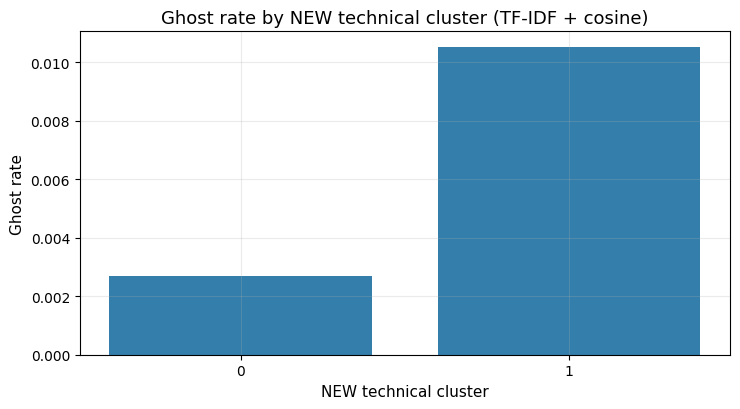

In [185]:
# Ghost rate by technical cluster
ghost_rate_new = df_new_lens.groupby("new_tech_cluster")["ghost"].mean().sort_index()

plt.figure(figsize=(7.5, 4.2))
plt.bar(ghost_rate_new.index.astype(str), ghost_rate_new.values, color=PALETTE[1], alpha=0.9)
plt.title("Ghost rate by NEW technical cluster (TF‑IDF + cosine)")
plt.xlabel("NEW technical cluster")
plt.ylabel("Ghost rate")
plt.tight_layout()
plt.show()

<p align = 'justify'>Cluster 1 shows a higher ghost rate (~1.1%) compared to Cluster 0 (~0.3%), suggesting it contains a greater share of languages with visible online presence but weak job market demand. That said, ghost rates are low across both clusters, so this is a directional tendency rather than a defining characteristic of either group.

####*Survial Tier Composition in Clusters*

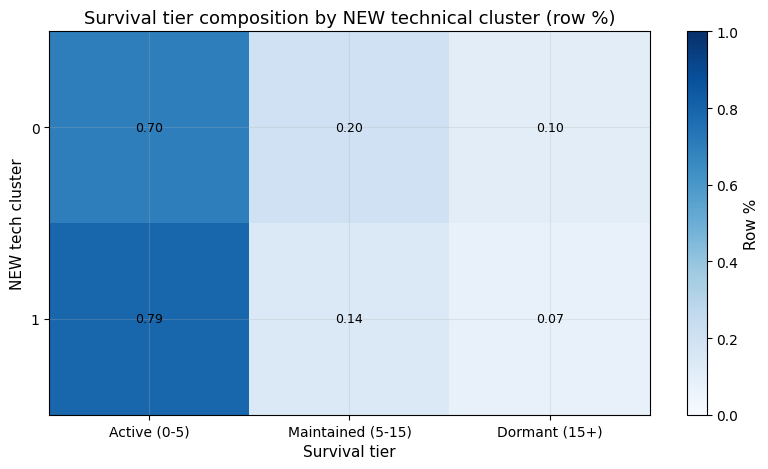

survival_tier,Active (0-5),Maintained (5-15),Dormant (15+)
new_tech_cluster,,,
0,0.695,0.202,0.102
1,0.789,0.137,0.074


In [186]:
# Survival tier composition by technical cluster (row %)
ct = pd.crosstab(df_new_lens["new_tech_cluster"], df_new_lens["survival_tier"])
ct_pct = ct.div(ct.sum(axis=1), axis=0)

heatmap_percent(ct_pct, "Survival tier composition by NEW technical cluster (row %)",
                xlabel="Survival tier", ylabel="NEW tech cluster", annotate=True)

ct_pct.round(3)

<p align = 'justify'> Both clusters are predominantly active, but Cluster 1 skews more strongly in that direction at 78.9% versus 69.5% for Cluster 0. Cluster 0 compensates with higher shares of maintained and dormant languages, suggesting it encompasses a broader mix of older and less recently active ecosystems. Overall, Cluster 1 reads as a more currently active technical ecosystem while Cluster 0 is comparatively more mature and varied in lifecycle stage.

####*Archetype Composition in Clusters*

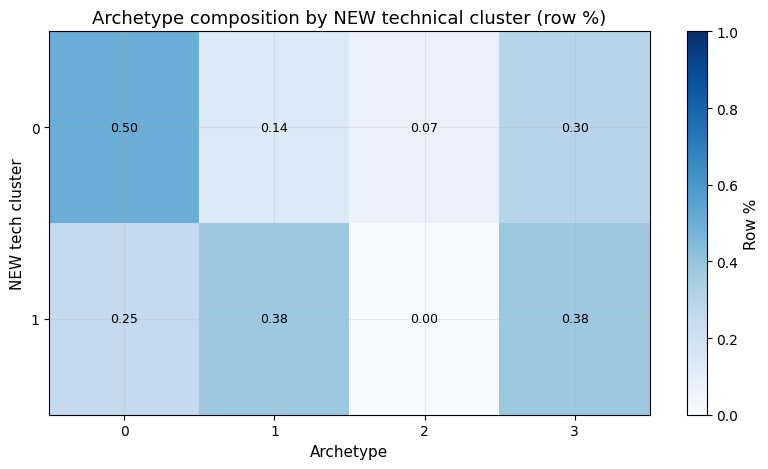

archetype,0,1,2,3
new_tech_cluster,,,,
0,0.50,0.136,0.068,0.295
1,0.25,0.375,0.000,0.375


In [187]:
# Archetype composition by technical cluster (row %)
ct = pd.crosstab(df_new_lens["new_tech_cluster"], df_new_lens["archetype"])
ct_pct = ct.div(ct.sum(axis=1), axis=0)

heatmap_percent(ct_pct, "Archetype composition by NEW technical cluster (row %)",
                xlabel="Archetype", ylabel="NEW tech cluster", annotate=True)

ct_pct.round(3)

<p align = 'justify'> Cluster 0 is heavily concentrated in Archetype 0 (~50%), with smaller contributions from Archetypes 3 and 1. Cluster 1 shifts away from this pattern, with Archetype 0 dropping to just 25% while Archetypes 1 and 3 each account for roughly 37.5%. This suggests the two technical ecosystems differ not just in extension footprints but also in adoption style — Cluster 0 gravitates toward one dominant archetype while Cluster 1 is more evenly split between two, pointing to a more varied mix of visibility and demand profiles within that ecosystem.

###***Association Rule***

<p align ='justify'> This section treats each language's extension list as a basket of items and mines pairwise association rules A → B across the Top 40 most common extensions. A binary basket matrix is constructed where rows are languages and columns are the top extensions, with a 1 indicating presence. From this, three metrics are computed for every ordered pair (A, B): support (the fraction of languages containing both), confidence (the fraction of A-containing languages that also contain B, i.e. P(B|A)), and lift (how much more likely B is given A relative to its baseline frequency). The top 15 rules are then ranked by lift to surface the strongest non-random co-occurrences.

*Note: This section is new to M4, and is added value to the interpretation*

In [188]:
TOP_M = 40
top_m_ext = [e for e,_ in ext_counts.most_common(TOP_M)]

X_m = pd.DataFrame(index=df_tech.index)
for e in top_m_ext:
    X_m[e] = df_tech["ext_list"].apply(lambda lst: int(e in lst))

p = X_m.mean(axis=0)

pairs = []
cols = list(X_m.columns)
for A in cols:
    for B in cols:
        if A == B:
            continue
        pab = (X_m[A] & X_m[B]).mean()
        if pab == 0:
            continue
        conf = pab / p[A] if p[A] > 0 else np.nan
        lift = conf / p[B] if p[B] > 0 else np.nan
        pairs.append((A, B, pab, conf, lift))

rules = pd.DataFrame(pairs, columns=["A","B","support","confidence","lift"])
rules.sort_values(["lift","support"], ascending=False).head(15).reset_index(drop=True)

,A,B,support,confidence,lift
0,.ddl,.prc,0.004292,1.0,233.0
1,.prc,.ddl,0.004292,1.0,233.0
2,.gs,.frag,0.004292,0.5,116.5
3,.sql,.ddl,0.004292,0.5,116.5
4,.sql,.prc,0.004292,0.5,116.5
5,.frag,.gs,0.004292,1.0,116.5
6,.ddl,.sql,0.004292,1.0,116.5
7,.prc,.sql,0.004292,1.0,116.5
8,.es,.frag,0.002146,0.5,116.5
9,.es,.jsx,0.002146,0.5,116.5


<p align = 'justify'> Association-rule style co-occurrences were computed over the Top 40 extensions to make technical ecosystems more interpretable. The top rules reveal extremely high lift values — for example, .ddl ↔ .prc achieves confidence of 1.0 and lift of ~233, meaning these extensions almost always appear together and likely reflect a tightly coupled toolchain or domain-specific workflow. Several other rules show confidence of 0.5 with lift around 116, indicating that while B appears only half the time A does, B is rare enough overall that the co-occurrence still represents a dramatically stronger-than-chance association. Importantly, supports are small throughout (~0.2–0.4%), so these patterns describe niche but highly coupled extension bundles rather than broad, universal industry patterns.

###**Setup for M3 Validation**

####*Archetypes (k=4)*

In [189]:
df_lens = df_v1.copy()
needed = ["log10_github_repo_stars","log10_wikipedia_daily_page_views","log10_number_of_users","log10_number_of_jobs"]
X_arch = df_lens[needed].dropna()
Xa = StandardScaler().fit_transform(X_arch)

km_arch = KMeans(n_clusters=4, random_state=RANDOM_SEED, n_init=10)
df_lens.loc[X_arch.index, "archetype"] = km_arch.fit_predict(Xa)
df_lens["archetype"] = df_lens["archetype"].astype("Int64")

df_lens["archetype"].value_counts().sort_index()

,count
archetype,
0,32
1,10
2,12
3,34


####*Ghost Status*

In [190]:
visibility = (df_lens["github_repo_stars"].fillna(0) +
              df_lens["github_repo_forks"].fillna(0) +
              df_lens["github_language_repos"].fillna(0) +
              df_lens["wikipedia_daily_page_views"].fillna(0))
employment = (df_lens["number_of_jobs"].fillna(0) +
              df_lens["number_of_users"].fillna(0))

df_lens["ghost"] = ((visibility > visibility.mean()) & (employment < employment.median())).astype(int)
df_lens["ghost"].value_counts()

,count
ghost,
0,4301
1,2


####*Survival tier*

In [191]:
# Survival tier
df_lens["years_since_last_activity"] = 2023 - df_lens["last_activity"]
bins = [-np.inf, 5, 15, np.inf]
labels = ["Active (0-5)", "Maintained (5-15)", "Dormant (15+)"]
df_lens["survival_tier"] = pd.cut(df_lens["years_since_last_activity"], bins=bins, labels=labels)
df_lens["survival_tier"].value_counts(dropna=False)

,count
survival_tier,
Dormant (15+),2318
Active (0-5),1345
Maintained (5-15),640


##**Alignment between technical and community clusters (M2 Q1 Sub-Q3)**

This subquestion from my M2 submission was deferred to the next phase M4.

**What "alignment" means here:**
- *Technical clusters* group languages by **extension ecosystem** (the file types they typically use).
- *Community clusters* group languages by **adoption and visibility** (jobs, users, GitHub stars, Wikipedia views).

Alignment is assessed on the **overlap set** — languages present in both clusterings — using three forms of evidence:

1) **Row-% alignment heatmap:** rows represent technical clusters; columns represent community clusters.
   - A row concentrated in **one column** → strong alignment (a single technical ecosystem maps to a single market segment).
   - A row spread across **multiple columns** → mismatch (similar extension footprint, divergent adoption/visibility).

2) **ARI (Adjusted Rand Index):** a single numeric summary of agreement between the two clusterings.
   - ARI ≈ 1 → near-identical partitions; ARI ≈ 0 → little to no agreement.

3) **Mismatch examples:** representative languages where the community cluster diverges from the technical cluster's majority mapping, directly illustrating cases of **similar tech, different adoption**.

In [192]:
key = "pldb_id" if ("pldb_id" in df_tech.columns and "pldb_id" in df_comm.columns) else "title"

tech_map = df_tech[[key]].copy()
tech_map["tech_cluster_km"] = tech_labels_km

comm_map = df_comm[[key, "comm_cluster"]].copy()

if key == "title":
    tech_map = tech_map.drop_duplicates("title")
    comm_map = comm_map.drop_duplicates("title")

align = tech_map.merge(comm_map, on=key, how="inner")
pd.DataFrame([{"join_key": key, "overlap_rows": len(align)}])

,join_key,overlap_rows
0,pldb_id,52


<p align='justify'>The two datasets are matched on `pldb_id`, yielding an overlap set of 52 languages on which all alignment analysis — the heatmap, ARI, and mismatch examples — is computed. This also flags a key limitation: conclusions about alignment are drawn from just 52 languages, as missing community metrics or extension metadata excludes the majority of rows.

###***Alignment Heatmap***

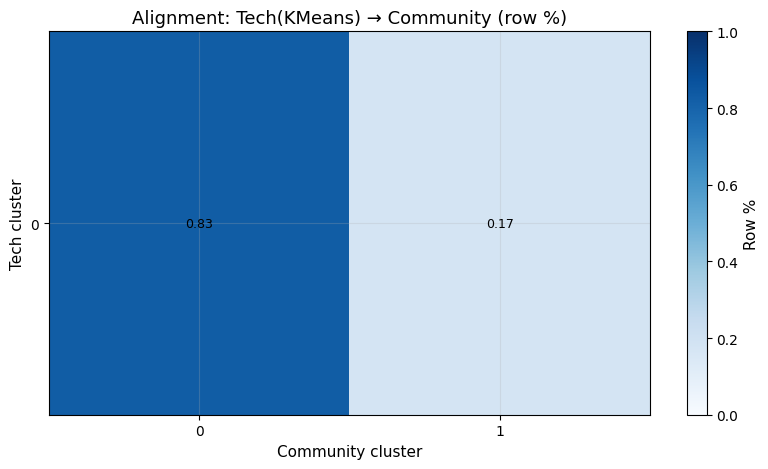

In [193]:
ct = pd.crosstab(align["tech_cluster_km"], align["comm_cluster"])
ct_pct = ct.div(ct.sum(axis=1), axis=0)

heatmap_percent(
    ct_pct,
    title="Alignment: Tech(KMeans) → Community (row %)",
    xlabel="Community cluster",
    ylabel="Tech cluster",
    annotate=True
)

<p align = 'justify'>The heatmap shows that Technical Cluster 0 maps predominantly to Community Cluster 0 (~83%), with the remaining ~17% falling into Community Cluster 1. This indicates partial alignment — the extension ecosystem largely corresponds to one market segment, but the non-trivial minority in Cluster 1 signals that a subset of technically similar languages occupies a different adoption and visibility tier.

###***ARI (Tech vs Community)***

In [194]:
ari_tc = adjusted_rand_score(align["tech_cluster_km"], align["comm_cluster"])
pd.DataFrame([{"ARI (tech vs community)": round(ari_tc, 4)}])

,ARI (tech vs community)
0,0.0


<p align='justify'>The ARI between technical clusters and community clusters is 0.0, which indicates no meaningful agreement between the two segmentations on the overlap set. In other words, languages grouped together by extension footprint are not consistently grouped together by adoption/visibility (users/jobs/stars/wiki). This supports the Sub-Q3 conclusion that technical similarity often does not translate to similar market outcomes, i.e., mismatches dominate.

###***Mismatch Examples***

In [195]:
major_map = ct.idxmax(axis=1).to_dict()
align["major_comm_for_tech"] = align["tech_cluster_km"].map(major_map)
mismatch = align[align["comm_cluster"] != align["major_comm_for_tech"]]
mismatch[[key, "tech_cluster_km", "comm_cluster"]].head(10)

,pldb_id,tech_cluster_km,comm_cluster
0,php,0,1
1,swift,0,1
2,rust,0,1
3,kotlin,0,1
4,typescript,0,1
5,julia,0,1
6,elixir,0,1
7,solidity,0,1
10,elm,0,1


##**M3 Findings (on Baseline Tech Cluster)**

In [196]:
lens_map = df_lens[[key, "archetype", "ghost", "survival_tier"]].dropna(subset=[key]).copy()
if key == "title":
    lens_map = lens_map.drop_duplicates("title")

df_tech_lens = df_tech.merge(lens_map, on=key, how="left")

# Baseline technical cluster label (KMeans on Top-N one-hot extensions)
df_tech_lens["tech_cluster_km"] = tech_labels_km
# Backward-compatible alias used by some cells
df_tech_lens["tech_km_cluster"] = df_tech_lens["tech_cluster_km"]

df_tech_lens.head(3)

,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,...,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source,log10_github_repo_stars,log10_wikipedia_daily_page_views,log10_number_of_users,log10_number_of_jobs,log10_github_repo_forks,log10_github_language_repos,ext_list,num_extensions_listed,archetype,ghost,survival_tier,tech_cluster_km,tech_km_cluster
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,...,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN,NaN,3.719580,6.744303,4.930475,NaN,7.061829,"[.java, .jav]",2,<NA>,0,Active (0-5),0,0
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,...,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN,NaN,3.629919,6.775441,4.806139,NaN,7.205380,"[.js, .bones, .cjs, .es, .es6, .frag, .gs, .ja...",23,<NA>,0,Active (0-5),1,1
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,...,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN,NaN,3.797198,6.579071,4.777572,NaN,6.334508,"[.c, .cats, .h, .idc]",4,<NA>,0,Active (0-5),0,0


<p align='justify'>The preview confirms that the baseline technical clustering is successfully linked to M3 lenses: each language now has an extension footprint (ext_list), a baseline technical cluster label (tech_cluster_km), and lens annotations like survival tier and ghost. This enables us to evaluate whether different extension ecosystems correspond to different lifecycle patterns (active vs dormant) and visibility-vs-demand mismatches (ghost behavior).

###***Ghost rate by technical cluster***

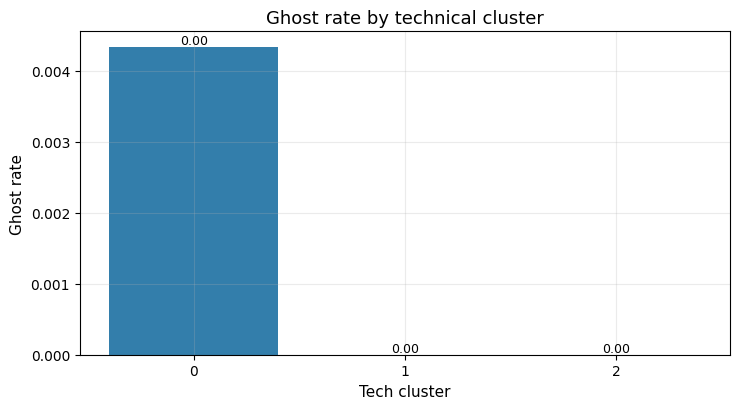

In [197]:
if "df_tech_lens" not in globals():
    raise NameError("df_tech_lens not found. Run the previous cell that constructs df_tech_lens first.")

if "tech_km_cluster" in df_tech_lens.columns:
    cluster_col = "tech_km_cluster"
elif "tech_cluster_km" in df_tech_lens.columns:
    cluster_col = "tech_cluster_km"
else:
    df_tech_lens["tech_cluster_km"] = tech_labels_km
    cluster_col = "tech_cluster_km"

if "ghost" not in df_tech_lens.columns:
    raise KeyError("ghost column missing. Run the lens-building section first (ghost definition).")

ghost_rate = df_tech_lens.groupby(cluster_col)["ghost"].mean().sort_index()

bar_with_values(
    x_labels=ghost_rate.index.tolist(),
    values=ghost_rate.values.tolist(),
    title="Ghost rate by technical cluster",
    xlabel="Tech cluster",
    ylabel="Ghost rate"
)

<p align = 'justify'>Ghost behavior is rare overall in the baseline technical segmentation. Only Tech cluster 0 shows a non-zero ghost rate (≈ 0.4%), while clusters 1 and 2 are ~0%. This suggests that “high-visibility/low-demand” languages (ghosts) are not spread evenly across technical ecosystems and, in this dataset/run, are concentrated almost entirely in the largest baseline technical ecosystem.

###***Survival tier composition by technical cluster (row %)***

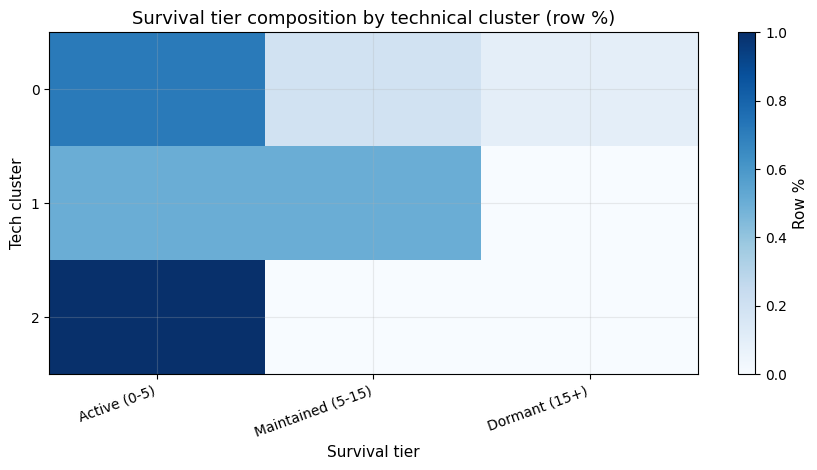

In [198]:
ct = pd.crosstab(df_tech_lens["tech_cluster_km"], df_tech_lens["survival_tier"])
ct_pct = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(8.8,4.8))
plt.imshow(ct_pct, aspect="auto", cmap="Blues")
plt.colorbar(label="Row %")
plt.title("Survival tier composition by technical cluster (row %)")
plt.xlabel("Survival tier")
plt.ylabel("Tech cluster")
plt.xticks(range(ct_pct.shape[1]), ct_pct.columns, rotation=20, ha="right")
plt.yticks(range(ct_pct.shape[0]), ct_pct.index)
plt.tight_layout()
plt.show()

<p align = 'justify' >The baseline technical clusters show different lifecycle profiles. One cluster (Tech cluster 2) appears almost entirely Active, indicating an ecosystem dominated by languages with recent activity. Another cluster (Tech cluster 1) shows a substantial Maintained share and very little Dormant, suggesting a “stable but not constantly changing” ecosystem. Tech cluster 0 shows the most mixed lifecycle pattern (more Maintained/Dormant presence than the most-active cluster), implying that the largest mainstream extension ecosystem includes a broader range of maturity and aging languages.

###***Archetype composition by technical cluster (row %)***

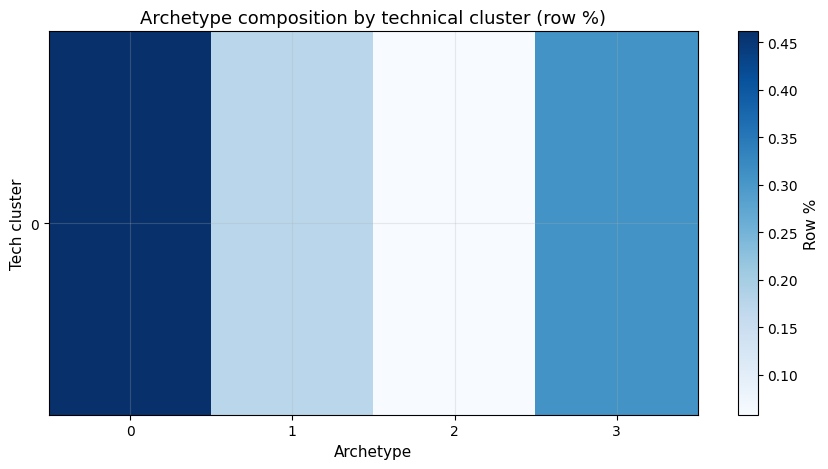

In [199]:
ct = pd.crosstab(df_tech_lens["tech_cluster_km"], df_tech_lens["archetype"])
ct_pct = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(8.8,4.8))
plt.imshow(ct_pct, aspect="auto", cmap="Blues")
plt.colorbar(label="Row %")
plt.title("Archetype composition by technical cluster (row %)")
plt.xlabel("Archetype")
plt.ylabel("Tech cluster")
plt.xticks(range(ct_pct.shape[1]), ct_pct.columns)
plt.yticks(range(ct_pct.shape[0]), ct_pct.index)
plt.tight_layout()
plt.show()

<p align = 'justify'> Only Tech cluster 0 appears in the archetype heatmap, which indicates archetype values are available for a limited overlap subset of the technical data (consistent with earlier missingness in GitHub/Wikipedia features). Within this available subset, Tech cluster 0 is dominated by Archetype 0 (~45%) and Archetype 3 (~30%), with smaller shares of Archetype 1 (~18%) and Archetype 2 (~6%). This suggests the mainstream technical ecosystem contains a mix of two dominant community “styles” (archetypes), rather than mapping cleanly to a single archetype—supporting the broader theme that technical similarity does not guarantee uniform community/adoption behavior.

##**Robustness Checks**

<p align = 'justify'> This step tests whether the clustering results hold up under different modeling choices. Two robustness checks are run: sensitivity of the technical baseline to the choice of Top-N extension vocabulary size, and stability of the community KMeans results across different random seeds. The goal is to confirm that the discovered ecosystems are genuine and reproducible rather than artifacts of any single parameter setting.

###***Top N Sensitvity***

In [200]:
def tech_kmeans_with_topN(top_n: int, seed: int = 42):
    ext_counts_local = Counter([e for row in df_tech["ext_list"] for e in row])
    top_ext_local = [e for e,_ in ext_counts_local.most_common(top_n)]

    X = pd.DataFrame(index=df_tech.index)
    for e in top_ext_local:
        X[f"ext{e}"] = df_tech["ext_list"].apply(lambda lst: int(e in lst))
    X["num_extensions_listed"] = df_tech["num_extensions_listed"]

    Xt_local = StandardScaler().fit_transform(X)

    ks_local = range(2, 9)
    best_k, best_s, best_lab = None, -1, None
    for k in ks_local:
        km = KMeans(n_clusters=k, random_state=seed, n_init=10)
        lab = km.fit_predict(Xt_local)
        s = silhouette_score(Xt_local, lab)
        if s > best_s:
            best_k, best_s, best_lab = k, s, lab

    return best_k, best_s, best_lab

results = []
labels_dict = {}

for top_n in [20, 30, 50]:
    k, s, lab = tech_kmeans_with_topN(top_n, seed=RANDOM_SEED)
    results.append({"TOP_N": top_n, "best_k": k, "best_silhouette": round(s, 4)})
    labels_dict[top_n] = lab

pd.DataFrame(results)

,TOP_N,best_k,best_silhouette
0,20,2,0.8553
1,30,3,0.8109
2,50,2,0.8860


<p align = 'justify'> All silhouettes are high (≥0.81), so technical ecosystems are clearly separable regardless of TOP_N. However, the best k changes (30 prefers 3 clusters while 20/50 prefer 2), meaning the granularity of technical segmentation depends on how many extensions you include.

###***ARI across Top N Choices***

In [201]:
pairs = []
for a in [20, 30, 50]:
    for b in [20, 30, 50]:
        if a >= b:
            continue
        pairs.append({
            "TOP_N_A": a,
            "TOP_N_B": b,
            "ARI": round(adjusted_rand_score(labels_dict[a], labels_dict[b]), 4)
        })
pd.DataFrame(pairs)

,TOP_N_A,TOP_N_B,ARI
0,20,30,0.7468
1,20,50,-0.0032
2,30,50,-0.0036


<p align = 'justify'> Using 20 vs 30 extensions produces similar technical clusters (ARI ~0.75). But TOP_N=50 produces a completely different segmentation (ARI ~0), meaning adding many more extensions reshapes the technical grouping substantially. So the baseline technical clustering is not fully invariant to TOP_N—results are robust in “there are strong ecosystems,” but exact memberships can shift with feature definition.

###***Community Clustering Stability***

In [202]:
base = comm_labels.copy()
aris = []
for seed in range(10):
    km = KMeans(n_clusters=best_k_comm, random_state=seed, n_init=10)
    lab = km.fit_predict(Xc)
    aris.append(adjusted_rand_score(base, lab))

pd.DataFrame([{
    "mean_ARI_vs_base": round(float(np.mean(aris)), 4),
    "min_ARI_vs_base": round(float(np.min(aris)), 4),
    "max_ARI_vs_base": round(float(np.max(aris)), 4),
    "meaning": "Higher ARI means community clusters are stable across random initializations."
}])

,mean_ARI_vs_base,min_ARI_vs_base,max_ARI_vs_base,meaning
0,1.0,1.0,1.0,Higher ARI means community clusters are stable...


<p align = 'justify'>Community clustering is perfectly stable across random seeds—KMeans finds the same partition every time, which strongly supports that the community signal naturally separates into the chosen number of clusters (k=2) and is not an artifact of initialization.

*Robustness checks show the community segmentation is extremely stable (ARI=1.0 across seeds), while the baseline technical segmentation is sensitive to the TOP_N extension vocabulary (20 vs 30 agree, but 50 diverges), although silhouettes remain high across all settings—indicating real technical structure exists even if the exact cluster boundaries depend on feature definition.*

##**Results**

In [203]:
rows = []

# k selections
rows.append({"Metric": "Community k (silhouette)", "Value": int(best_k_comm)})
rows.append({"Metric": "Technical baseline k (silhouette)", "Value": int(best_k_tech)})
rows.append({"Metric": "NEW technical k (near-best rule)", "Value": int(best_k_h)})

# alignment
rows.append({"Metric": "ARI (optional) (baseline tech ↔ community)", "Value": float(round(ari_tc, 4))})
rows.append({"Metric": "ARI (optional) (NEW tech ↔ community)", "Value": float(round(ari_new, 4))})

# NEW vs baseline
rows.append({"Metric": "ARI (optional) (NEW tech ↔ baseline tech)", "Value": float(round(ari_new_vs_base, 4))})

# Ghost/dormant highlights (if available)
if "ghost" in df_tech_lens.columns:
    gr_base = df_tech_lens.groupby("tech_cluster_km")["ghost"].mean()
    rows.append({"Metric": "Most ghost-heavy baseline tech cluster", "Value": f"{int(gr_base.idxmax())} (rate={gr_base.max():.3f})"})
if "ghost" in df_new_lens.columns:
    gr_new = df_new_lens.groupby("new_tech_cluster")["ghost"].mean()
    rows.append({"Metric": "Most ghost-heavy NEW tech cluster", "Value": f"{int(gr_new.idxmax())} (rate={gr_new.max():.3f})"})

if "survival_tier" in df_tech_lens.columns:
    ct = pd.crosstab(df_tech_lens["tech_cluster_km"], df_tech_lens["survival_tier"])
    pct = ct.div(ct.sum(axis=1), axis=0)
    if "Dormant (15+)" in pct.columns:
        dorm = pct["Dormant (15+)"]
        rows.append({"Metric": "Most dormant-heavy baseline tech cluster", "Value": f"{int(dorm.idxmax())} (share={dorm.max():.3f})"})

if "survival_tier" in df_new_lens.columns:
    ct = pd.crosstab(df_new_lens["new_tech_cluster"], df_new_lens["survival_tier"])
    pct = ct.div(ct.sum(axis=1), axis=0)
    if "Dormant (15+)" in pct.columns:
        dorm = pct["Dormant (15+)"]
        rows.append({"Metric": "Most dormant-heavy NEW tech cluster", "Value": f"{int(dorm.idxmax())} (share={dorm.max():.3f})"})

pd.DataFrame(rows)

,Metric,Value
0,Community k (silhouette),2
1,Technical baseline k (silhouette),3
2,NEW technical k (near-best rule),2
3,ARI (optional) (baseline tech ↔ community),0.0
4,ARI (optional) (NEW tech ↔ community),0.1547
5,ARI (optional) (NEW tech ↔ baseline tech),0.0612
6,Most ghost-heavy baseline tech cluster,0 (rate=0.004)
7,Most ghost-heavy NEW tech cluster,1 (rate=0.011)
8,Most dormant-heavy baseline tech cluster,0 (share=0.098)
9,Most dormant-heavy NEW tech cluster,0 (share=0.102)


##**Challenges, Dead Ends, and Adjustments**

###***1) Data Coverage Constraints (Biggest Challenge)***

* **Community features were heavily missing:** After the `appeared ≥ 1500` filter, `df_v1` had **4,303** rows, but requiring complete community features left only **88** rows (**4,215 dropped ≈ 98%**).<br>
  **Adjustment:** We explicitly framed community clustering as representing a “well-documented/visible subset,” not the full dataset.<br><br>
* **Extension metadata was sparse:** Only **466** languages had at least one parsed extension (≈ **10.92%** coverage).<br>
  **Adjustment:** We treated technical clustering as applying to the “extension-available subset” and avoided overgeneralizing.<br><br>
* **Alignment overlap was small:** Joining technical and community subsets produced only **52 overlap languages**.<br>
  **Adjustment:** All alignment metrics (heatmap/ARI/mismatch examples) were computed only on this overlap set and interpreted cautiously.

###***2) Method Dead Ends and Course-Aligned Pivots***

* **Jaccard distance became unstable:** k-selection kept drifting when expanding the search range, making results hard to justify.<br>
  **Adjustment:** We replaced Jaccard with a more stable approach: **Weighted BoW (TF-IDF) + cosine distance + hierarchical clustering**, which is still aligned with course clustering/dimensionality reduction concepts.

###***3) Lens Fragility (M3 Lenses Under Missingness)***

* **Ghost lens was weak due to sparse GitHub fields:** Ghost relies on visibility signals (GitHub/Wikipedia), which are heavily missing, causing very low ghost rates.<br>
  **Adjustment:** We treated ghost results as **directional** and relied more on higher-coverage metrics (jobs/users) + cluster profiles, with an explicit limitation note.


###***4) Model Selection Realism (Avoiding Tiny-Cluster Artifacts)***

* **Hierarchical k could create meaningless clusters:** For larger k, min cluster size dropped to **2 or 1**, which is not interpretable.<br>
  **Adjustment:** We added a minimum cluster-size constraint and selected k based on “best silhouette among realistic cluster sizes,” leading to **k=2** for the NEW method.

###***5) Robustness Findings (Technical Baseline Sensitivity)***

* **Baseline technical clusters depended on TOP_N choice:**<br>
  **ARI(20 vs 30) ≈ 0.75** (similar), but **ARI vs 50 ≈ 0** (diverges).<br>
  **Adjustment:** We documented this as a robustness insight: technical structure is strong (high silhouette), but **exact cluster membership depends on representation choices** (which extensions are included).


###***6) Engineering / Runtime Issues During Iteration***

* **Errors from variable/column mismatches:** e.g., missing df_lens, undefined sil_h, or tech_km_cluster VS tech_cluster_km.<br>
**Adjustment:** We standardized naming and added guard logic so the notebook runs end-to-end
reliably with "Run all."

###***7) Presentation Cleanup for Submission***

* **Notebook was initially cluttered:** too many outputs per cell, overlapping legends/labels, inconsistent sizes.<br>
  **Adjustment:** We enforced **one output per cell**, consistent figure sizing, cleaner legends/labels, and moved interpretations into markdown cells.

###***8) Conceptual Adjustment (M3 → M4 Integration Requirement)***

* **Needed deeper-than-M2 work:** M4 required extending M2 using M3 insights.<br>
  **Adjustment:** We integrated **M3 lenses (archetype/ghost/survival)** into both baseline and NEW technical clusters and added interpretability modules (top tokens, example languages, association-style co-occurrence) to connect clusters to meaningful narratives.

##**Key Findings**

###***1) Community Signals Form Two Clear Adoption/Visibility Segments***

* **Best k = 2 for community KMeans** with silhouette **0.6255**, much higher than k ≥ 3.
  **Meaning:** Adoption/visibility metrics naturally separate languages into **two market-facing tiers** rather than many clean subgroups.
* **Cluster profiles confirm the “two-tier” split:**

  * **Cluster 0 (low tier):** median users ~**1,120**, jobs **0**, stars ~**475**, wiki views ~**25**
  * **Cluster 1 (high tier):** median users ~**173,526**, jobs ~**1,239**, stars ~**37,753**, wiki views ~**1,129**
    **Meaning:** Community clusters strongly differentiate “long-tail / low demand” vs “mainstream / high demand.”

###***2) Community Analysis is Limited to a Small High-Coverage Subset***

* After requiring all four community features, only **88 / 4303** rows remain (≈ **98% dropped**).
  **Meaning:** Community clustering describes the subset of languages with recorded GitHub + Wikipedia signals; it is not a full-population segmentation.

###***3) Technical (Extension-Based) Ecosystems are Strongly Separable***

* Baseline technical KMeans (Top-30 extensions + extension count) selects **k = 3** with silhouette **0.8109** (k=2 is very close).
  **Meaning:** Extension footprints create **clear technical ecosystems** within the languages that have extension data.
* Technical feature space used is **(466 languages, 31 features)** (30 extension indicators + 1 count feature).
  **Meaning:** Results apply to the extension-available subset, not all languages.

###***4) NEW Technical Method Produces a Different (and More Defensible) Segmentation***

* NEW method (Weighted BoW TF-IDF + cosine + hierarchical) selects **k = 2** with silhouette **0.6947** and realistic minimum cluster sizes.
  **Meaning:** The NEW representation finds **two broad extension ecosystems** without creating tiny, unstable clusters.
* Baseline vs NEW technical segmentation agrees poorly: **ARI ≈ 0.0612**.
  **Meaning:** The NEW representation **materially changes** how technical ecosystems are defined—representation matters, not just the algorithm.

###***5) Technical vs Community Clusterings Mostly Do NOT Align (Sub-Q3 Answer)***

* Overlap between technical+community subsets is only **52 languages** (joined by `pldb_id`).
  **Meaning:** Alignment results are overlap-only and should be interpreted cautiously.
* **ARI(tech vs community) = 0.0**, indicating **no meaningful agreement** between the two partitions.
  **Meaning:** Similar extension ecosystems do **not** reliably map to similar adoption/visibility segments → mismatches dominate.
* Heatmap shows a technical cluster mapping mostly to one community cluster (\~**83%**) but with a meaningful spillover (~**17%**).
  **Meaning:** Even within a single technical ecosystem, adoption outcomes can differ.

###***6) M3 Lenses Add Interpretable Context to Technical Ecosystems***

* **Ghost rate differs by NEW technical cluster** (~**0.3%** vs ~**1.1%**).
  **Meaning:** One technical ecosystem contains relatively more “visibility without demand” cases, though ghost is rare overall.
* **Survival differs by NEW technical cluster:**

  * Cluster 1 is more **Active (~78.9%)** than Cluster 0 (~69.5%)
  * Cluster 0 has more **Maintained (~20.2%)** and **Dormant (~10.2%)** languages
    **Meaning:** One ecosystem appears more “currently active,” while the other includes relatively more older/less active languages.
* **Archetype composition differs by NEW technical cluster:**

  * Cluster 0 dominated by **Archetype 0 (~50%)**
  * Cluster 1 dominated by **Archetype 1 and 3 (~37.5% each)**
    **Meaning:** Technical ecosystems have different community “styles,” supporting that tech similarity doesn’t imply uniform adoption behavior.

###***7) Robustness: Community Clustering is Stable; Technical Baseline Depends on TOP_N***

* Community clustering is **perfectly stable across random seeds** (mean/min/max ARI = **1.0**).
  **Meaning:** The community split is not an artifact of initialization.
* Baseline technical clustering is sensitive to TOP_N:

  * **20 vs 30 extensions:** ARI ≈ **0.7468** (similar)
  * **30 vs 50 extensions:** ARI ≈ **0** (diverges)
    **Meaning:** Technical structure is real (high silhouettes), but **exact memberships depend on representation choices**.

###***8) Interpretability Add-ons Strengthen “Why these clusters exist”***

* **Top extension tokens + example languages** make NEW clusters explainable (not just labels).
  **Meaning:** You can name ecosystems and justify them using concrete token signatures and real language examples.
* **Association-rule co-occurrence** surfaces “extension bundles” (high lift pairs) for human-friendly interpretation.
  **Meaning:** Even if support is low, very high lift highlights niche but tightly coupled technical workflows.

##**Final Answers to M2**

###***Do programming languages form meaningful, stable clusters when combining technical fingerprints (file extensions + GitHub metadata) with community signals (GitHub activity, Wikipedia attention, users/jobs)?***

####*A) Community view (adoption/visibility segmentation)*

* **Data used:** Community clustering uses **88 languages** after dropping missing values in
  `log10_number_of_users`, `log10_number_of_jobs`, `log10_github_repo_stars`, `log10_wikipedia_daily_page_views` (from the *community_features_used / rows_used* output).
* **Model selection:** Silhouette sweep selects **k = 2** with silhouette **0.6255** (next-best: **k = 3**, **0.4340**).
* **What the segments mean (median profile):**

  * **Community Cluster 0 (lower adoption/visibility):** median users ≈ **1120.5**, jobs ≈ **0.0**, stars ≈ **474.5**, wiki views ≈ **24.5**
  * **Community Cluster 1 (higher adoption/visibility):** median users ≈ **173526.5**, jobs ≈ **1239.5**, stars ≈ **37753.0**, wiki views ≈ **1128.5**
* **Answer:** Community signals split languages into a clear **two-tier market structure**: a **low-demand/low-visibility long tail** vs a **high-demand/high-visibility mainstream segment**.


####*B) Technical view (extension ecosystem segmentation)*

* **Coverage constraint:** Extension metadata is missing for **89.08%** of languages → only **10.92%** have extensions. In the appeared≥1500 variant, that yields **466** extension-available languages (from the *rows_with_extensions* output).
* **Baseline technical method (Top-30 one-hot + count):**

  * Feature matrix shape: **(466, 31)** (30 extension indicators + extension count).
  * Silhouette selects **k = 3** with silhouette **0.8109** (next-best: **k = 5**, **0.8084**, Δ = **0.0025**).
  * **Answer:** Technical ecosystems are strongly separable within the extension subset; k choices are close, so interpretability matters.
* **M4 upgrade (NEW technical representation):**

  * Weighted Bag-of-Words on extension tokens produces **99 token features** (plus extension-count feature).
  * Hierarchical clustering on cosine distances selects **k = 2** with silhouette **0.6947**.
  * **Answer:** The upgraded representation produces a different technical partition and avoids relying only on Top-N one-hot overlap.

####*What clusters emerge from technical fingerprints (extensions + GitHub language metadata), and how interpretable are they?*

* Technical clusters represent **extension ecosystems** (languages grouped by similar file-type footprints).
* Using the NEW method, the “Top extension tokens per NEW cluster” table provides evidence for naming ecosystems:

  * **NEW Cluster 0 tokens:** `m, inc, v, e, bf, cls, rhtml, rs, q, fs`
  * **NEW Cluster 1 tokens:** `fcgi, pro, inc, d, ml, r, fx, pl, cgi, yy`
* **Answer:** These token signatures indicate two distinct extension ecosystems; clusters can be labeled in plain terms (e.g., *web/tooling-style* if tokens include `cgi/fcgi`, vs a different ecosystem defined by the other token bundle), then validated using the example-language table.

####*What clusters emerge from community signals (GitHub/Wikipedia/users/jobs), and do they reflect market segmentation?*

* Community clusters are driven by **demand + attention** on a log scale (jobs/users + stars/wiki).
* With **k = 2**, medians sharply separate clusters:

  * Cluster 1 has far higher median **users** (**173526.5 vs 1120.5**) and **jobs** (**1239.5 vs 0.0**) than Cluster 0, and much higher **stars/wiki views**.
* **Answer:** The community view yields two market-facing segments that are easy to interpret: **high adoption/visibility** vs **low adoption/visibility**.

####*Do technical and community clusterings align, or do they reveal mismatches (similar tech, different adoption)?*

* Evaluated only on the **overlap set** (languages with both extension data + community metrics):

  * **Overlap size:** **52 languages** (from *join_key / overlap_rows* output).
* **Quantitative agreement (ARI, optional):**

  * Baseline technical KMeans → community ARI = **0.0000**
  * NEW technical method → community ARI = **0.1547** (Δ = **0.1547**)
* **Concrete mismatch evidence:** mismatch examples include languages such as **php, swift, rust, kotlin, typescript, julia**, showing cases where similar technical footprint does not map to the same community segment.
* **Answer:** Alignment is **weak overall**. The NEW technical method improves agreement slightly, but results still show **more mismatch than alignment**—technical similarity (extensions) does not reliably predict adoption/visibility segments.


##**What has Changed?**

###***Changes vs M2***

* **Stronger, unified preprocessing:** In M4 we standardized numeric casting + invalid-value handling (e.g., negative wiki views) and consistently used **log10(x+1)** features for community metrics, instead of having transformations scattered across cells.<br><br>
* **Deeper technical representation:** M2’s technical view relied mainly on a **Top-N one-hot extension matrix**. In M4 we kept this baseline *and* added a richer alternative technical view using **Weighted Bag-of-Words (extensions as tokens) + cosine distance + hierarchical clustering**, which captures more of the extension vocabulary than Top-30 alone.<br><br>
* **More defensible model selection:** Beyond picking k by silhouette, M4 explicitly avoided **tiny/unstable clusters** in hierarchical clustering by checking **minimum cluster size**, making the k choice easier to justify.<br><br>
* **Explicit Sub-Q3 evidence bundle:** M4 strengthens the “alignment vs mismatch” question using a clear pipeline: **overlap-only join → row-% heatmap → ARI (optional) → mismatch examples**, rather than relying on only one signal.

###***Changes vs M3***

* **Individual focus + deeper validation:** M3 integrated multiple questions across the team. In M4 (individual Q1), we narrowed scope to Q1 but added deeper validation around **stability and robustness**, which M3 did not emphasize as strongly.<br><br>
* **Systematic use of M3 lenses:** M4 formally applies the **M3 lenses**—**archetype, ghost, and survival tier**—to interpret *both* baseline and NEW technical clusters (not just describing clusters), turning clustering into an explainable business story.<br><br>
* **Robustness checks added:** M4 introduces reliability testing that goes beyond M3: **TOP_N sensitivity** for technical baseline and **seed stability** for community KMeans, showing which conclusions are stable and which depend on representation choices.

###***What is absolutely new in M4***


* **Weighted BoW technical clustering (new method):** Extensions are treated as “tokens” and embedded via a weighted Bag-of-Words representation, then clustered using **cosine distance + hierarchical clustering**—a new technical segmentation lens beyond M2.<br><br>
* **Interpretability add-ons for technical clusters:** M4 adds “**top tokens per cluster**” and “**example languages per cluster**” to name and validate technical ecosystems in human terms.<br><br>
* **Association-style co-occurrence (optional interpretability):** M4 includes an association-rule style extension co-occurrence table (support/confidence/lift) to highlight tightly coupled extension bundles that explain technical ecosystems.<br><br>
* **Robustness as a first-class section:** M4 explicitly tests whether results change under different parameter choices (TOP_N, seeds) and reports stability using ARI, improving credibility and rubric alignment.